# Parameter generation of HF-MO system

In [12]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v
from espei.datasets import load_datasets, recursive_glob
from espei.plot import dataplot
import matplotlib.pyplot as plt
from espei.plot import plot_endmember, plot_parameters,plot_interaction

## Load parameter generation setting yaml file and run 

In [17]:
with open('generate_params_settings.yaml') as fp:
    generate_params_settings = yaml.safe_load(fp)
    
dbf = run_espei(generate_params_settings)

INFO:espei.espei_script - espei version       0.8.6
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.paramselect - Generating parameters.
INFO:espei.paramselect - FITTING: BCC_A2
INFO:espei.paramselect - FITTING: FCC_A1
INFO:espei.paramselect - FITTING: HCP_A3
INFO:espei.paramselect - FITTING: LAVES_C14
INFO:espei.paramselect - FITTING: LAVES_C15
INFO:espei.paramselect - FITTING: LAVES_C36
INFO:espei.paramselect - FITTING: LIQUID
INFO:espei.paramselect - Finished generating parameters.


## Plot the phase diagram based on the TDB generated by parameter selection

<AxesSubplot:title={'center':'HF-MO'}, xlabel='X(HF)', ylabel='Temperature (K)'>

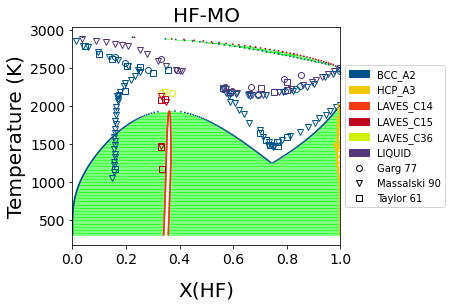

In [34]:
# starting TDB after parameter selection
comps = ['HF', 'MO', 'VA']
phases = ['LIQUID', 'BCC_A2', 'HCP_A3', 'LAVES_C15', 'LAVES_C14', 'LAVES_C36']
#phases = list(dbf.phases.keys())
#print(phases)
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 3000, 10), v.X('HF'): (0, 1, 0.01)}
ax = binplot(dbf, comps, phases, conds)
datasets = load_datasets(recursive_glob('input_data', '*.json'))
dataplot(comps, phases, conds, datasets, ax=ax)

### G and H of Equilibrium calculation

In [3]:
dbf = Database('dft.tdb')
comps = ['HF', 'MO', 'VA']
eq_result = equilibrium(dbf, comps ,'LAVES_C15', {v.X('HF'):(0,1,0.1), v.T: (1500), v.P:101325},output='HM')
print(eq_result.GM)
print(eq_result.HM)

<xarray.DataArray 'GM' (N: 1, P: 1, T: 1, X_HF: 10)>
array([[[[ 57374.24517918,  -8672.92547502, -59512.485139  ,
          -89218.87485286, -94282.90956095, -88845.01106445,
          -83407.11256747, -77969.21407054, -72531.31557357,
          -67093.41707665]]]])
Coordinates:
  * N        (N) float64 1.0
  * P        (P) float64 1.013e+05
  * T        (T) float64 1.5e+03
  * X_HF     (X_HF) float64 1e-10 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9
<xarray.DataArray 'HM' (N: 1, P: 1, T: 1, X_HF: 10)>
array([[[[165792.34183061, 105011.88320622,  57157.88211671,
           28743.62725323,  27605.09590762,  35343.34488429,
           43081.59386062,  50819.84283696,  58558.09181331,
           66296.34078969]]]])
Coordinates:
  * N        (N) float64 1.0
  * P        (P) float64 1.013e+05
  * T        (T) float64 1.5e+03
  * X_HF     (X_HF) float64 1e-10 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9


### Calculating Energy Surfaces of Binary Systems

Text(0.5, 0, 'X(HF)')

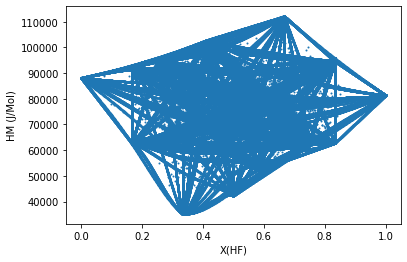

In [102]:
%matplotlib inline
dbf = Database('dft.tdb')
phases = list(dbf.phases.keys())
cr = calculate(dbf, ['MO', 'HF', 'VA'], 'LAVES_C36', N=1, P=101325, T=1800, pdens=pdens,output='HM')
plt.scatter(cr.X.sel(component='HF'), cr.HM.squeeze(), label=phase_name, s=1)
plt.ylabel('HM (J/Mol)')
plt.xlabel('X(HF)')


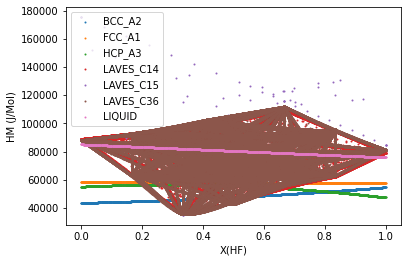

In [103]:
for phase_name in phases:
    if phase_name == 'LAVES_C15':
        pdens = 10
    else:
        pdens = 1000
    cr = calculate(dbf, ['MO', 'HF', 'VA'], phase_name, N=1, P=101325, T=1800, pdens=pdens,output='HM')
    plt.scatter(cr.X.sel(component='HF'), cr.HM.squeeze(), label=phase_name, s=1)

#print(cr)
plt.ylabel('HM (J/Mol)')
plt.xlabel('X(HF)')
plt.legend()

## Understanding parameter generation

### Plot the LAVES_C15 (HF)(MO) endmember

/Users/shuanglin/opt/anaconda3/envs/espei/lib/python3.9/site-packages/espei/plot.py:78: FutureWarning: `espei.plot.plot_parameters` is deprecated and will be removed in ESPEI 0.9. Please use `plot_endmember` or `plot_interaction` instead.
  warnings.warn(deprecation_msg, category=FutureWarning)


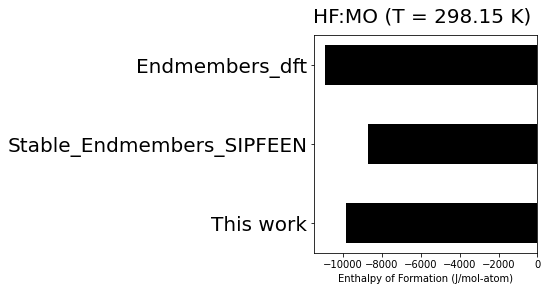

In [18]:
plot_parameters(dbf, comps, 'LAVES_C15', (('HF'), ('MO')), symmetry=None, datasets=datasets)  

### Plot the mixing interaction in the first sublattice of LAVES_C15 phase

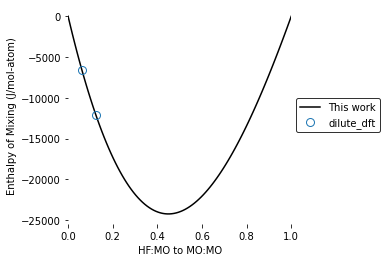

In [94]:
plot_parameters(dbf, comps, 'LAVES_C15', (('HF','MO'),('MO')), symmetry=None, datasets=datasets)  